### Frame by frame analysis for robust lane marking

#### 1. introduction of the project

This notebook presents the analysis performed on individual image to compute lane lines for Advanced Lane Finding project for Udacity's self-driving car nanodegree. This notebook specifically deals with identifying the lane mask, and then computing the lane location and polynomial mask for the road.

The following discription describe the image processing method step by step. 



###### Part 1 helper fuctions. First of all, I define the functions to analyse the image. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import tensorflow as tf
from scipy import signal
import os
import math
from numpy.polynomial import Polynomial as P


PREV_LEFT_X1 = None
PREV_LEFT_X2 = None
PREV_RIGHT_X1 = None
PREV_RIGHT_X2 = None

BASE_IMG = None
CANNY_IMG = None

%matplotlib inline

def birdview(img):
    
    dst1 = cv2.warpPerspective(img,M,(img_size[1],img_size[0]),flags=cv2.INTER_LINEAR)
    return dst1

#define the sobel filter detect the edge of the lane 
def sobel_thresh (image, thresh_g_min,thresh_g_max,thresh_dir_min,thresh_dir_max):
    
    image = cv2.GaussianBlur(image,(5,5),0)
    
    image_x = cv2.Sobel(image,cv2.CV_64F,1,0, 5)
    image_y = cv2.Sobel(image,cv2.CV_64F,0,1, 5)
    
    abs_x = np.abs(image_x)
    abs_y = np.abs(image_y)
    
    img_g = np.sqrt(image_x**2+image_y**2)
    img_dir = np.arctan2(abs_y, abs_x)
    img_g = np.uint8(img_g*255/np.max(img_g))
    #img_dir = np.uint8(img_dir*255/np.max(img_dir))
    
    s_dir = np.zeros_like(img_dir)
    s_dir[(img_dir >= thresh_dir_min) & (img_dir <= thresh_dir_max)] = 1
    
    s_g = np.zeros_like(img_g)
    s_g[(img_g >= thresh_g_min) & (img_g <= thresh_g_max)] = 1
    
    #th1,img_g = cv2.threshold(img_g, thresh, max_value, cv2.THRESH_BINARY);
    #th1,img_dir = cv2.threshold(img_dir, thresh_dir, max_value, cv2.THRESH_BINARY);
    
    #img = cv2.bitwise_and(img_g, img_dir)
    
    binary_output = np.zeros_like(img_g)
    binary_output[(s_dir == 1)&(s_g == 1)]=1
    
    return binary_output

#define the function to run the sobel filter on the l and s channel of the image 
def hlv_sobel(img):
    h, l, s = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HLS))
    #img_h = sobel_thresh(h,50,255,0.5,1.2) 
    #plt.imshow(255*img_g, cmap ='gray')
    #print(img_h)
    #print(np.shape(img_h))
    img_s = sobel_thresh(s,35,255,1,120)
    img_l = sobel_thresh(l,35,255,1,120)
    image_hsv_sobel = cv2.bitwise_and(img_s,img_l)
    return image_hsv_sobel

#define s color mask to find the lane, the color mask is robut to shadow
def image_mask(image):

    image_HSV = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    #print(image_HSV[450,:,0])

    #use a for loop to normalize the image_HSV in Range 0 to 255
    #for i in range(3):
    #image_HSV[:,:,i] = np.uint8(image_HSV[:,:,i]*255/np.max(image_HSV[:,:,i]))

    #print(image_HSV[:,:,1], np.max(image_HSV[:,:,2]))

    yellow_hsv_low = np.array([ 10, 100, 100],np.uint8)
    yellow_hsv_high = np.array([ 80, 255, 255],np.uint8)

    white_hsv_low = np.array([20, 0, 180],np.uint8)
    white_hsv_high = np.array([255,  100, 255],np.uint8)


    #image_HSV = np.uint8(image_HSV*255/np.max(image_HSV))

    res_mask_yellow = cv2.inRange(image_HSV,yellow_hsv_low,yellow_hsv_high)
    res_yellow = cv2.bitwise_and(image,image, mask = res_mask_yellow)
 
    #print(image_HSV[200,:,0])
    #print(image_HSV[200,:,1])
    #print(image_HSV[200,:,2])
    res_mask_white = cv2.inRange(image_HSV,white_hsv_low,white_hsv_high)
    res_white = cv2.bitwise_and(image,image, mask = res_mask_white)
    
    #combine the yellow and white masked images
    mask_lane = cv2.bitwise_or(res_yellow,res_white)
    mask_lane_g = cv2.cvtColor(mask_lane, cv2.COLOR_RGB2GRAY)
    #Lane = np.zeros_like(mask_lane)
    #Lane[(mask_lane_g>=.5)|(image_hsv_sobel>=.5)]=1
    return mask_lane_g

#combine the image from sobel filter and the color mask
def CombineImage(image_sobel,image_mask):
    Lane = np.zeros_like(image_sobel)
    Lane[(image_sobel>=.5)|(image_mask>=.5)]=1
    #Lane = image_mask
    warp = cv2.warpPerspective(Lane, M_inv, (1280, 720))
    #mask = np.array
    #mask = 0*mask
    
    #Lane = cv2.bitwise_and(Lane,Lane,mask = mask)
    
    #Lane = cv2.bitwise_and()
    return warp


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def slope(line):
    return (float(line[3]) - line[1]) / (float(line[2]) - line[0])

#define the the draw_line function to draw the line back on the image 
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    global PREV_LEFT_X1, PREV_LEFT_X2, PREV_RIGHT_X1, PREV_RIGHT_X2
    left_x = []
    left_y = []
    right_x = []
    right_y = []

    for line in lines:
        #print(line)
        line = line[0]
        s = slope(line)
        #print(s)

        if 0.5 > s > -0.5:
            continue

        if s < 0:
            if line[0] > img.shape[1] / 2 :
                continue

            left_x += [line[0], line[2]]
            left_y += [line[1], line[3]]
            # cv2.line(img, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])), [0, 0, 255], thickness)
        else:
            if line[0] < img.shape[1] / 2 :
                continue

            right_x += [line[0], line[2]]
            right_y += [line[1], line[3]]
            # cv2.line(img, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])), [255, 255, 0], thickness)

    y1 = img.shape[0]
    y2 = img.shape[0]/2 + 90
    #y2 = 0

    if len(left_x) <= 1 or len(right_x) <= 1:
        if PREV_LEFT_X1 is not None:
            cv2.line(img, (int(PREV_LEFT_X1), int(y1)), (int(PREV_LEFT_X2), int(y2)), color, thickness)
            cv2.line(img, (int(PREV_RIGHT_X1), int(y1)), (int(PREV_RIGHT_X2), int(y2)), color, thickness)
        return

    left_poly = P.fit(np.array(left_x), np.array(left_y), 1)
    right_poly = P.fit(np.array(right_x), np.array(right_y), 1)

    left_x1 = (left_poly - y1).roots()
    right_x1 = (right_poly - y1).roots()

    left_x2 = (left_poly - y2).roots()
    right_x2 = (right_poly - y2).roots()

    if PREV_LEFT_X1 is not None:
        left_x1 = PREV_LEFT_X1 * 0.4 + left_x1 * 0.6
        left_x2 = PREV_LEFT_X2 * 0.4 + left_x2 * 0.6
        right_x1 = PREV_RIGHT_X1 * 0.4 + right_x1 * 0.6
        right_x2 = PREV_RIGHT_X2 * 0.4 + right_x2 * 0.6

    PREV_LEFT_X1 = left_x1
    PREV_LEFT_X2 = left_x2
    PREV_RIGHT_X1 = right_x1
    PREV_RIGHT_X2 = right_x2

    cv2.line(img, (int(left_x1), int(y1)), (int(left_x2), int(y2)), color, thickness)
    cv2.line(img, (int(right_x1), int(y1)), (int(right_x2), int(y2)), color, thickness)


def Canny_edge(img, low_threshold, high_threshold):
    #img_G = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #plt.imshow(img_G, cmap = 'gray')
    img_G = cv2.GaussianBlur(img, (9, 9), 0)
    
    return cv2.Canny(img, low_threshold, high_threshold)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,Oimg):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    #print(lines[0],np.shape(lines))
    draw_lines(line_img, lines)
    return line_img

def image_processing(img):
    #get the image size
    img_size = np.shape(img)
    
    #bird view transformation
    image_bv = birdview(img)
    
    #apply the color mask to the image
    img_mask = image_mask(image_bv)
    
    #gray scale image
    img_G = cv2.cvtColor(image_bv, cv2.COLOR_RGB2GRAY)
    
    #apply canny detector to the image
    image_edge = Canny_edge(img_G,70,90)
    
    #combine the result
    image_cmb1 = np.zeros_like(masked_image)
    image_cmb1[(masked_image>=.5)|(image_edge>=.5)]=1
    
    #inverse transform the combined image to the original size
    warp = cv2.warpPerspective(image_cmb1, M_inv, (img_size[1], img_size[0]))
    
    #hough line transformation to find the line and draw line back to the original image
    lines = hough_lines(warp, 2, np.pi/180, 50, 200, 300,img)
    
    
    final_image = cv2.addWeighted(img, 1, lines, 1, 0)
    
    return final_image



###### Part 2 How to detect the lane on a image

step 1: define the global variable to hold the value of the x1,x2,y1,y2 of the left and right side lane from the 
previous frame. It help me to draw the lane even if the lane can't be detected.

step 2: define the function to transform the region of interst to the bird view image

step 3: apply color mask to find the yellow and white lane in the image

step 4: apply canny detector to the l and s channel of the image. We could find out that the s channel is resistant to the noise of shadows (like shadow of trees in the challenge video). 

step 5: apply the canny edge detector to the gray scale image.

step 6: combine the output images from above (I ignored the s channel canny detected image)

step 7: Do the reverse perspective transformation to 

step 8: do the hough space transformation to get the lane on the image.

step 9: draw the line back on a blank image.

step 10: add the image with lines on it and the original image to get the final image


(720, 1280, 3) 1280


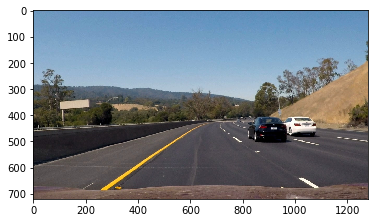

In [2]:
img = mpimg.imread('frame0.jpg')
img_size = np.shape(img)

#define the region of interest, this parameter set is based on the challenge video

ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0]*0.96)
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .23*np.uint(img_size[1]/2)
cbl_window = c_window - .7*np.uint(img_size[1]/2)
cbr_window = c_window + .85*np.uint(img_size[1]/2)

src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

#get the matrix M for the perspective transform

M = cv2.getPerspectiveTransform(src,dst)
M_inv = cv2.getPerspectiveTransform(dst,src)

print(img_size, img_size[1])
plt.imshow(img)

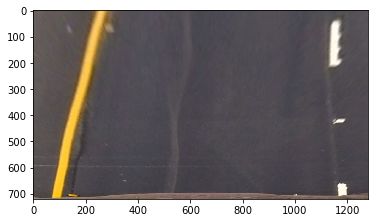

In [3]:
#bird view tranformation
image_bv = birdview(img)
plt.imshow(image_bv)

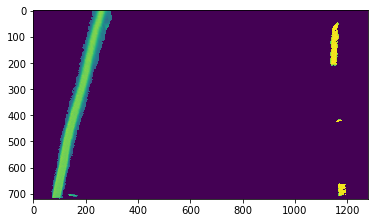

In [4]:
#apply color mask to get the yellow and white lanes
img_mask = image_mask(image_bv)
plt.imshow(img_mask)

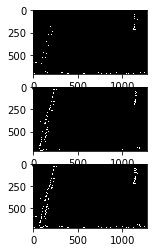

In [5]:
#apply the canny edge detector to the s and l channel of the image, the s channel is robust to shadow
h, l, s = cv2.split(cv2.cvtColor(image_bv, cv2.COLOR_RGB2HLS))

image_l = Canny_edge(l,60,80)
image_s = Canny_edge(s,60,80)

image_ls = np.zeros_like(h)

image_ls[(image_l>=.5)|(image_s>=.5)]=1

plt.subplot(3,1,1)
plt.imshow(image_l, cmap = 'gray')
plt.subplot(3,1,2)
plt.imshow(image_s, cmap = 'gray')
plt.subplot(3,1,3)
plt.imshow(image_ls, cmap = 'gray')

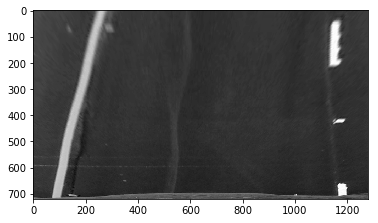

In [6]:
#gray scale iamge 
img_G = cv2.cvtColor(image_bv, cv2.COLOR_RGB2GRAY)
plt.imshow(img_G, cmap = 'gray')
#print(img_G[150,:])

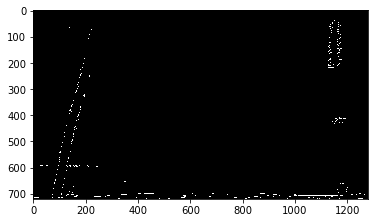

In [7]:
#apply canny edge detector the the gray scale image
image_edge = Canny_edge(img_G,70,90)
plt.imshow(image_edge, cmap = 'gray')

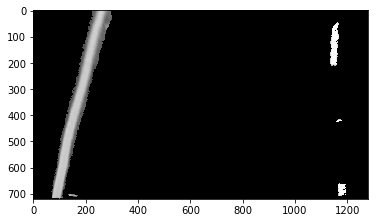

In [8]:
#apply color mask
masked_image = image_mask(image_bv)
plt.imshow(masked_image, cmap = 'gray')

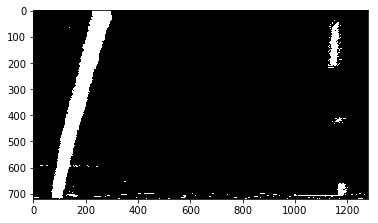

In [9]:
#combine the images
image_cmb1 = np.zeros_like(masked_image)
image_cmb1[(masked_image>=.5)|(image_edge>=.5)]=1
plt.imshow(image_cmb1, cmap = 'gray')

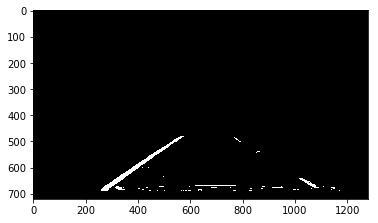

In [10]:
warp = cv2.warpPerspective(image_cmb1, M_inv, (img_size[1], img_size[0]))
plt.imshow(warp, cmap = 'gray')

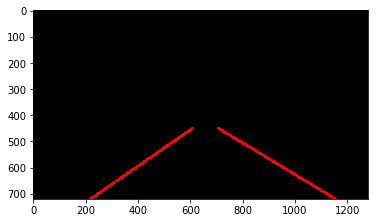

In [11]:
#hough line transformation 
line_image = hough_lines(warp, 2, np.pi/180, 50, 200, 300, img)
plt.imshow(line_image)
#print(lines)

In [12]:
#warp = cv2.warpPerspective(line_image, M_inv, (img_size[1], img_size[0]))
#plt.imshow(warp)

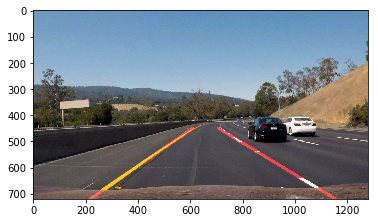

In [13]:
final_image = cv2.addWeighted(img, 1, line_image, 1, 0)
plt.imshow(final_image)

###### Part 3 Pipeline function 

In [14]:
def image_processing(img):
    #get the image size
    img_size = np.shape(img)
    
    #bird view transformation
    image_bv = birdview(img)
    
    #apply the color mask to the image
    img_mask = image_mask(image_bv)
    
    #gray scale image
    img_G = cv2.cvtColor(image_bv, cv2.COLOR_RGB2GRAY)
    
    #apply canny detector to the image
    image_edge = Canny_edge(img_G,70,90)
    
    #combine the result
    image_cmb1 = np.zeros_like(masked_image)
    image_cmb1[(masked_image>=.5)|(image_edge>=.5)]=1
    
    #inverse transform the combined image to the original size
    warp = cv2.warpPerspective(image_cmb1, M_inv, (img_size[1], img_size[0]))
    
    #hough line transformation to find the line and draw line back to the original image
    lines = hough_lines(warp, 2, np.pi/180, 50, 200, 300,img)
    
    
    final_image = cv2.addWeighted(img, 1, lines, 1, 0)
    
    return final_image

###### Part 4 Video processing 

The region of interst for solidWhiteRight.mp4 video 

In [15]:
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0]*0.96)
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .23*np.uint(img_size[1]/2)
cbl_window = c_window - .7*np.uint(img_size[1]/2)
cbr_window = c_window + .85*np.uint(img_size[1]/2)

src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

In [16]:
PREV_LEFT_X1 = None
PREV_LEFT_X2 = None
PREV_RIGHT_X1 = None
PREV_RIGHT_X2 = None

BASE_IMG = None
CANNY_IMG = None

new_clip_output = 'raw-challenge.mp4'
test_clip = VideoFileClip("challenge.mp4")
new_clip = test_clip.fl_image(image_processing)#NOTE: this function expects color images!!
%time new_clip.write_videofile(new_clip_output, audio=False)


[MoviePy] >>>> Building video raw-challenge.mp4
[MoviePy] Writing video raw-challenge.mp4
[MoviePy] Done.                                                        
[MoviePy] >>>> Video ready: raw-challenge.mp4 

CPU times: user 25.4 s, sys: 2.46 s, total: 27.9 s
Wall time: 21.5 s


In [17]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))

